In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading keras and FBD experiment...
from keras import backend as K
K.set_floatx('float32')
from helpers import *
from model_conv import *
from experiment_model import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np
from IPython.display import Image, display

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input
from keras.layers import Activation, Conv2D, Conv1D

# loading resnet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions

Using TensorFlow backend.


Initialized TensorFlow


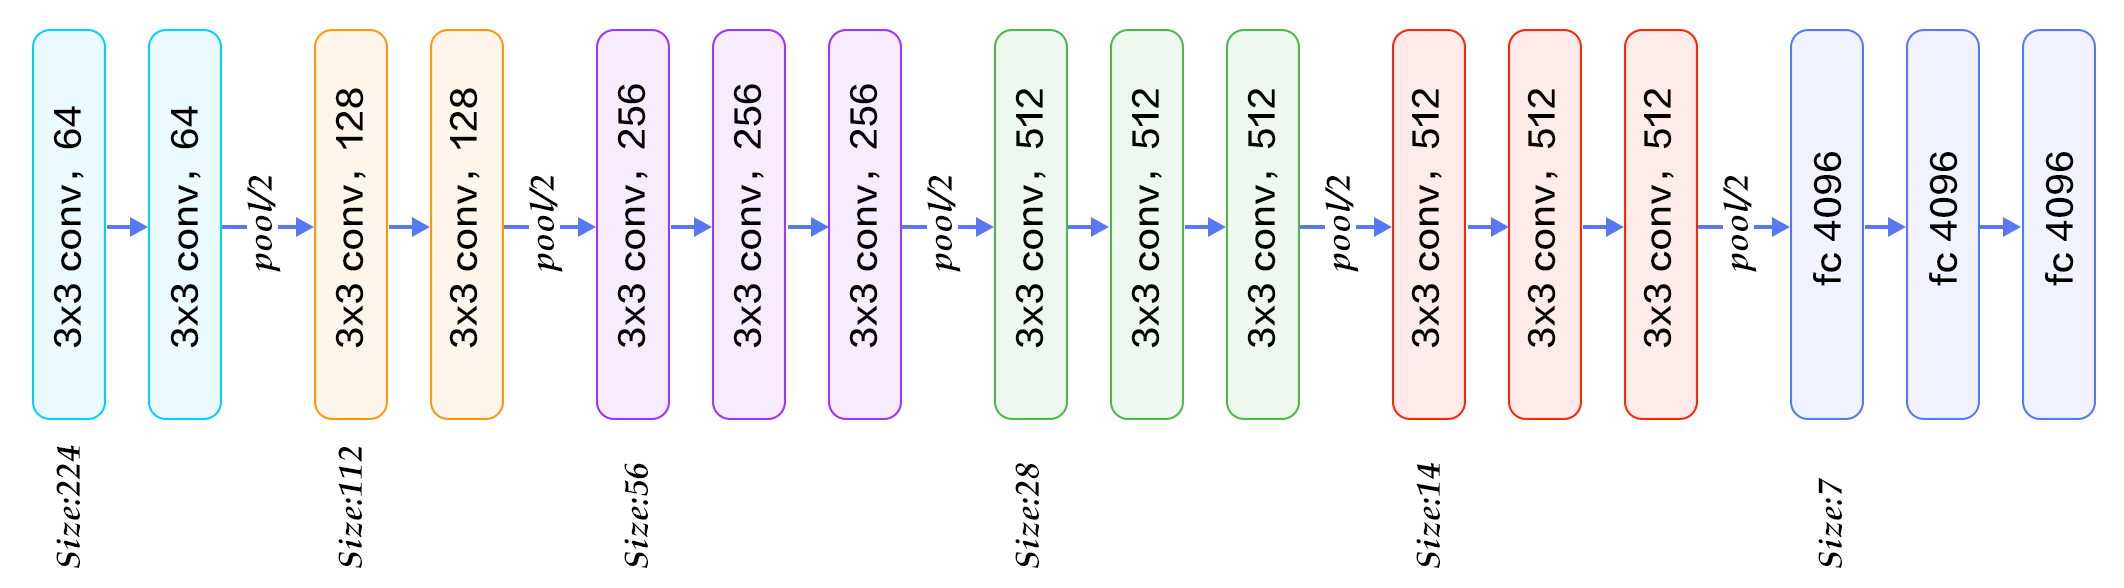

In [2]:
# creating vgg16 model
model = VGG16(weights = 'imagenet')

# replacing max pooling with average
model = pool_max2avg(model)

# removing top softmax activation
model = remove_activation(model, -1)

# replacing ReLU with Softplus(2)
model = replace_relu_with_softplus(model, scaler = 2.0)

# output layer
l = -1

Replaced maxpool to avgpool at layers [2, 5, 9, 13, 17]
Removing activation from layer -1
Applying modifications...


/localhome/volodin/miniconda3/envs/rl/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Replacing ReLU to Softplus(2.00)
Replaced activations {'relu'} on layers [1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17, 20, 21] with softplus
Applying modifications...


In [3]:
# choosing only this output layer
model = cut_and_flatten(model, l)

# pooling input
model = poolinput(model, pooling = 10)

In [4]:
# making input grayscale
model = grayscale(model)

In [5]:
# inactive
#d = 10
#model_upscale = upscale_from(model_cut, d)

In [5]:
#!googleimagesdownload --keywords "Cat,dog" --limit 20

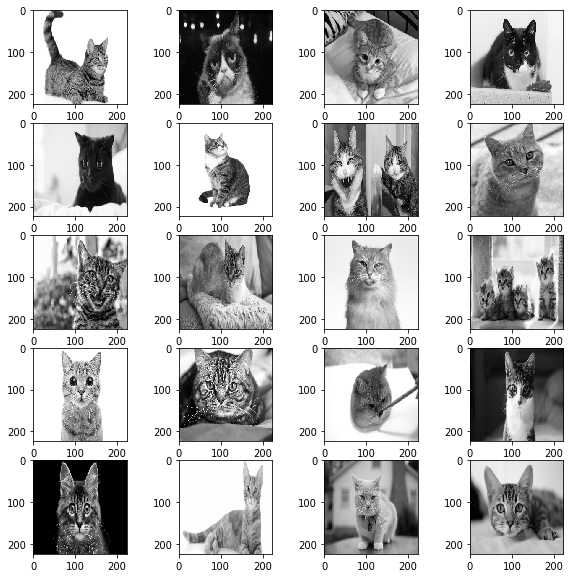

In [6]:
# directory with images
dr = 'downloads/Cat/'

# all images
images = os.listdir(dr)

# loading the cat image
xs = []
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
axes = axes.flatten()
for i, img in enumerate(images):
    # normalize /255 -> bad predictions
    x = load_image(dr + img, axis = axes[i]) * 255.
    xs.append(x)
plt.show()
xs = np.mean(xs, axis = 1)

In [7]:
# making only 10 entries in the red channel column 0 faulty
#rc0 = 10
#x, x_without_first = split_x_rc0(x, rc0 = rc0)

In [8]:
# create a model which adds the rest
#model = merge_with_taken(model, x_without_first, rc0 = rc0)

In [9]:
for x in xs:
    x = np.array([x])
    if l == -1:
        print(decode_predictions(model.predict(x), top=3)[0])
    else:
        print(model.predict(x))

[('n04270147', 'spatula', 537.09064), ('n03498962', 'hatchet', 520.5332), ('n03041632', 'cleaver', 506.81598)]
[('n03825788', 'nipple', 388.54608), ('n04579145', 'whiskey_jug', 375.80756), ('n03544143', 'hourglass', 362.49918)]
[('n02074367', 'dugong', 466.76218), ('n03041632', 'cleaver', 457.27225), ('n02606052', 'rock_beauty', 428.5855)]
[('n03041632', 'cleaver', 328.17053), ('n03498962', 'hatchet', 321.09384), ('n04270147', 'spatula', 320.05508)]
[('n04357314', 'sunscreen', 376.91833), ('n03690938', 'lotion', 363.44385), ('n03623198', 'knee_pad', 349.20657)]
[('n02074367', 'dugong', 477.52515), ('n03825788', 'nipple', 454.50897), ('n03498962', 'hatchet', 429.40405)]
[('n04270147', 'spatula', 639.531), ('n03476991', 'hair_spray', 622.2283), ('n03041632', 'cleaver', 613.6143)]
[('n04086273', 'revolver', 435.4703), ('n03041632', 'cleaver', 431.55292), ('n03498962', 'hatchet', 425.00754)]
[('n04270147', 'spatula', 599.29364), ('n03041632', 'cleaver', 590.15204), ('n03476991', 'hair_spra

In [10]:
# probability of input failure
p = 0.000001

In [11]:
# calculating np
n = np.prod(list(map(int, model.inputs[0].shape[1:])))
repetitions = 100
n, n * p * repetitions * len(xs)

(50176, 100.352)

In [12]:
# keeping indices with the largest output probability
top_predictions = 5
to_keep = np.array(np.argsort(-model.predict(xs[1:2]))[0][:top_predictions], dtype = np.int32)

In [13]:
print('Keeping output indices ' + ', '.join([str(t) for t in to_keep]))

Keeping output indices 680, 901, 604, 772, 503


In [14]:
# model with only these indices kept
model = keep_oindices(model, to_keep)

In [15]:
# obtaining experiment from a model
exp = ModelInputCrashExperiment(model, p = p)

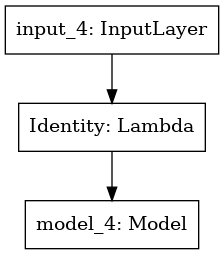

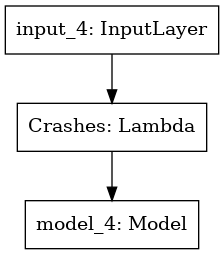

In [16]:
# showing correct/crashing models
display(Image(model_to_dot(exp.model_correct, ).create(prog='dot', format='png'), width = 80))
display(Image(model_to_dot(exp.model_crashing).create(prog='dot', format='png'), width = 80))

In [17]:
# crashing prediction
decode_predictions(predict_kept(exp.model_crashing, x, to_keep), top=3)[0]

[('n03825788', 'nipple', 350.7898254394531),
 ('n04127249', 'safety_pin', 348.9385681152344),
 ('n03062245', 'cocktail_shaker', 325.80718994140625)]

In [18]:
# correct prediction
decode_predictions(predict_kept(exp.model_correct, x, to_keep), top=3)[0]

[('n03825788', 'nipple', 350.7898254394531),
 ('n04127249', 'safety_pin', 348.9386291503906),
 ('n03062245', 'cocktail_shaker', 325.8072204589844)]

In [19]:
# get theoretical error (bound b3)
theoretical = exp.get_bound_b3(np.array(xs))

In [20]:
# get experimental error
experimental = experiment_mean_std(exp, xs, repetitions = repetitions)

In [21]:
def process(key = 'mean', plot = True):
    """ Process data for theory/experiment """
    t, e = theoretical[key], experimental[key]
    print('Shapes', t.shape, e.shape)
    z = np.linalg.norm(t - e) / np.linalg.norm(e)
    print("Norm delta", z)
    
    if plot:
        for out_dim in range(t.shape[1]):
            plt.scatter(t[:,out_dim], e[:,out_dim])
        plt.xlabel('Theory')
        plt.ylabel('Experiment')
        xs = np.linspace(np.min(e), np.max(e), 10)
        plt.plot(xs, xs)
        plt.title('Components: ' + key)
        plt.ticklabel_format(style='sci', axis='x')
        plt.show()

        plt.xlabel('Theory')
        plt.ylabel('Experiment')
        plt.title('Norm: ' + key)
        z = np.linalg.norm(e, axis = 1)
        xs = np.linspace(np.min(z), np.max(z), 10)
        plt.plot(xs, xs)
        z1 = np.linalg.norm(t, axis = 1)
        print('2*Rank loss %.2f%%' % (200*rank_loss(z, z1)))
        plt.scatter(z1, z)
        plt.show()
    return z

Shapes (20, 5) (20, 5)
Norm delta 0.9866502438325718


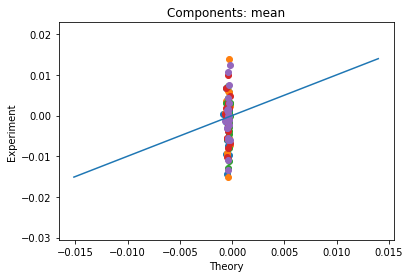

2*Rank loss 108.42%


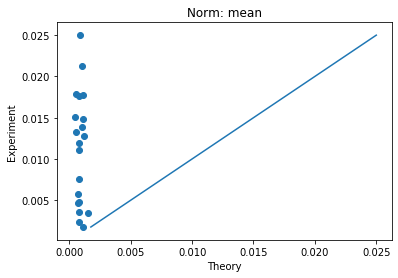

array([0.01763151, 0.00356364, 0.00239513, 0.01329903, 0.01792311,
       0.00762564, 0.01273128, 0.00473633, 0.00175336, 0.02500063,
       0.01483422, 0.00339307, 0.01775057, 0.01105876, 0.01192463,
       0.00466211, 0.01506124, 0.0138208 , 0.02125674, 0.00576397])

In [22]:
process('mean')

Shapes (20, 5) (20, 5)
Norm delta 0.4690995930262149


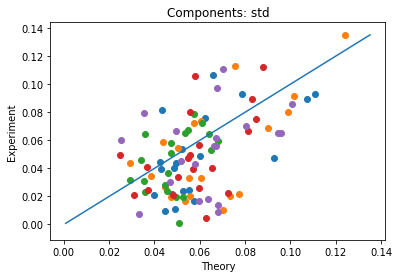

2*Rank loss 70.53%


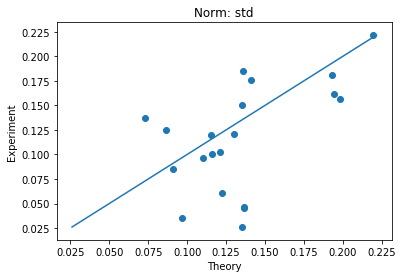

array([0.10087034, 0.03538959, 0.02607991, 0.12481097, 0.10294282,
       0.1851983 , 0.09630705, 0.04622349, 0.0453025 , 0.15694086,
       0.2214676 , 0.16171957, 0.18093395, 0.12077398, 0.12012598,
       0.08476609, 0.13717042, 0.15074932, 0.17620049, 0.06087273])

In [23]:
process('std')

Problem: experimental mean is not in line with theory. Variance is much better. Why? Trying various methods (remove top softmax, full image/only some pixels/many images instead of 1/plotting 1st component only/plotting norm difference/grayscale) -- still same result.

Problem: input filter created discontinuity, NOT intermediate layers..

A bit better for large p for some reason. The expansion holds for small p, as it's an expansion over p

p 10^-3 grayscale full image 1000, 5000 repetitions bad mean, ~ok variance

In [58]:
# Does the model have any batch norm at input?
# does not seem so
model.layers[2].layers

In [150]:
# why is 5000 repetitions enough for the mean to stabilize? probability is really small, so
# we only cover a tiny subset of all possibilities... plotting mean(repetitions)
# seems to stabilize
x_test = xs[0:1]
def get_dta(reps):
    experimental = experiment_mean_std(exp, x_test, repetitions = reps)
    return experimental['mean'][0][0]
R = [1,2,3] + [int(t) for t in np.linspace(10, 500, 10)]
d = [get_dta(r) for r in tqdm(R)]



  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 17.12it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.04it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.13it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  2.75it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.05it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  1.63it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.33it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.13it/s]

100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


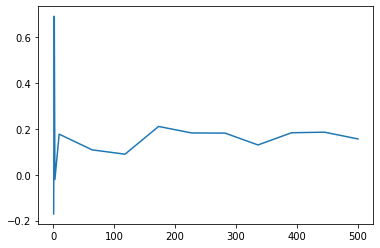

In [151]:
plt.plot(R, d)

In [152]:
# maybe the computation is bad? trying manually
m = exp.model_correct
bound = -p * tf.reduce_sum((tf.multiply(tf.gradients(m.output[:, 0], m.layers[0].output)[0], m.layers[0].output)), axis = [1,2])
sess = get_session()
z = exp.compute_error(x_test, 5000)[0,:,0]

0.15645137
[-0.00863074]


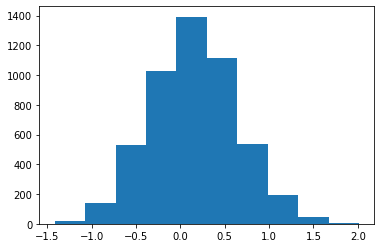

In [195]:
plt.hist(z)
print(np.mean(z))
print(sess.run(bound, {m.input: x_test}))
# why is there such a HUGE difference???

In [236]:
# Trying a simpler model: sum(x) -- must have a trivial result
# E Delta = -px
# Works great

#input_tensor = Input(shape = (224, 224))
model1 = Sequential()
model1.add(InputLayer(input_shape = (224, 224,)))
model1.add(Lambda(lambda x : tf.expand_dims(tf.reduce_sum(x, axis=[1,2]), 1)))

exp1 = ModelInputCrashExperiment(model1, p = 0.001)

# get theoretical error (bound b3)
theoretical = exp1.get_bound_b3(x_test)

# get experimental error
experimental = experiment_mean_std(exp1, x_test, repetitions = 500)

print(theoretical, experimental)

{'mean': array([[-10077.349]], dtype=float32), 'std': array([[1518.844]], dtype=float32)} {'mean': array([[-10129.938]], dtype=float32), 'std': array([[1577.5563]], dtype=float32)}


In [245]:
# trying with a mean: OK
# trying with a sigmoid: OK
# Trying a simpler model with a non-linearity

#input_tensor = Input(shape = (224, 224))
model1 = Sequential()
model1.add(InputLayer(input_shape = (224, 224,)))
model1.add(Lambda(lambda x : tf.expand_dims(tf.sigmoid(tf.reduce_mean(x, axis=[1,2]) / 1000.), 1)))

exp1 = ModelInputCrashExperiment(model1, p = 0.01)

# get theoretical error (bound b3)
theoretical = exp1.get_bound_b3(x_test)

# get experimental error
experimental = experiment_mean_std(exp1, x_test, repetitions = 500)

print(theoretical, experimental)

{'mean': array([[-0.00049707]], dtype=float32), 'std': array([[2.3691084e-05]], dtype=float32)} {'mean': array([[-0.00049775]], dtype=float32), 'std': array([[2.3914967e-05]], dtype=float32)}


In [4]:
# doesn't work: 

In [5]:
d = 100
x_test = np.ones((1, d, 1))
sess = get_session()

In [22]:
def simple_model(activation = 'softplus', initializer = None):
    model = Sequential()
    #add model layers
    model.add(keras.layers.pooling.AveragePooling1D(pool_size=10, input_shape=(d, 1)))
    model.add(Conv1D(1, bias_initializer = 'ones', kernel_size=3, activation=activation))
    model.add(Flatten())
    model.add(Dense(1, kernel_initializer = 'ones', bias_initializer = 'ones', activation = 'linear'))
        #print(model.output)
    return model

In [23]:
# Trying a simple model with a conv layer
def modeltest(p = 0.01, repetitions = 10000):
    global model
    print("Out", np.mean(model.predict(x_test)))
    print('np', p * d)
    
    exp1 = ModelInputCrashExperiment(model, p = p)

    global theoretical, experimental
    
    # get theoretical error (bound b3)
    theoretical = exp1.get_bound_b3(x_test)

    # get experimental error
    experimental = experiment_mean_std(exp1, x_test, repetitions = repetitions)
    
    print(theoretical, experimental)

    # all results
    results = {key: process(key, plot = False) for key in ['mean', 'std']}
    
    return [results[key] for key in ['mean', 'std']]

In [30]:
reps = list(map(int, np.logspace(2, 4, 3)))

In [31]:
def plot_result(res, log = False):
    res = np.array(res)
    plt.figure()
    plt.ylabel('Error %')
    if log:
        plt.xscale('log')
    plt.plot(reps, res[:, 0] * 100, label = 'mean')
    plt.plot(reps, res[:, 1] * 100, label = 'std')
    plt.legend()
    plt.show()

Summary for convtest

n=100 p=0.01
1. Linear+ones -> OK 2% 10^3
2. Softplus+ones -> OK 2% 10^3
3. Linear+Normal -> OK 2% 10^3
4. Linear+glorot uniform -> OK 2% 10^4
5. Softplus+glorot uniform -> 2% 10^4 now 2%??
6. Softplus+glorot 2-6 -> 2% at 10^6 and 10^4??

n=100 p=0.07
5. Softplus+glorot uniform -> 2% 10^4 now 5%

6. Softplus + no initializer -> weird mean 200% error, repeat -> fine --- model-dependent
7. linear + no initializer -> 2%

In [38]:
model = simple_model(activation = 'softplus', initializer = 'ones')

In [39]:
model.layers[1].get_weights()

[array([[[ 0.2783847]],
 
        [[ 0.7385638]],
 
        [[-0.6368079]]], dtype=float32), array([1.], dtype=float32)]

In [40]:
res = [modeltest(repetitions = r, p = 0.07) for r in tqdm(reps)]

  0%|          | 0/3 [00:00<?, ?it/s]

Out 13.836143
np 7.000000000000001


 33%|███▎      | 1/3 [00:00<00:01,  1.94it/s]

{'mean': array([[-0.170093]], dtype=float32), 'std': array([[0.10344747]], dtype=float32)} {'mean': array([[-0.16367469]]), 'std': array([[0.10239206]])}
Shapes (1, 1) (1, 1)
Norm delta 0.03921383117354164
Shapes (1, 1) (1, 1)
Norm delta 0.01030750228778398
Out 13.836143
np 7.000000000000001


 67%|██████▋   | 2/3 [00:00<00:00,  2.01it/s]

{'mean': array([[-0.170093]], dtype=float32), 'std': array([[0.10344747]], dtype=float32)} {'mean': array([[-0.16511222]]), 'std': array([[0.09800438]])}
Shapes (1, 1) (1, 1)
Norm delta 0.030166053488668697
Shapes (1, 1) (1, 1)
Norm delta 0.055539240185266646
Out 13.836143
np 7.000000000000001


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

{'mean': array([[-0.170093]], dtype=float32), 'std': array([[0.10344747]], dtype=float32)} {'mean': array([[-0.16525592]]), 'std': array([[0.09772978]])}
Shapes (1, 1) (1, 1)
Norm delta 0.029270248053094267
Shapes (1, 1) (1, 1)
Norm delta 0.058505055236037815


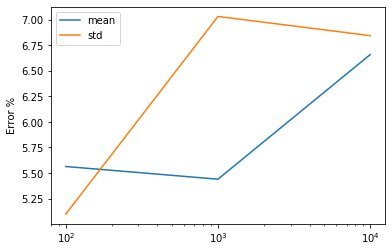

In [35]:
plot_result(res, log = 'True')

In [26]:
# trying only conv layers NOTOK
# l=2 NOTOK
# l=3 not OK
# l=1 NOTOK -- WHY?
# l=0 OK

# tried: float64
# Tried: pool max->avg NOT OK

1. ALSO NEED TO SMOOTH W.T in order not to have unused input neurons. For example, small conv filter [-1,1] is not fault-tolerant: p% of failures results in Var,EDelta~p. Both vardelta and EDelta suffer. Metric: #changes (integrated W'' and not W') over number of neurons -> how redundant the network is

2. Conv pooling helps on input. But if pooling neurons crash, we have a huge problem.